# Autoencoder

### All Imports

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import numpy as np
import matplotlib.pyplot as plt

from icecream import ic


from sklearn.metrics import precision_recall_fscore_support, roc_curve, auc
from torch.utils.data import DataLoader, Subset

print("Imported Everything!")


Imported Everything!


### Device

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print("Device:", device)

Device: cuda


### Autoencoder Class

In [9]:
class AutoEncoder(nn.Module):
    def __init__(self, bottleneck_dim):
        super(AutoEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28*28, 128),
            nn.ReLU(),
            nn.Linear(128, bottleneck_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(bottleneck_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 28*28),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded.view(-1, 1, 28, 28)


### Loading MNIST Dataset

In [10]:
BATCH_SIZE = 64
EPOCHS = 20

transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.MNIST(root="./data", train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root="./data", train=False, transform=transform, download=True)

NORMAL_DIGIT = 2022111031 % 10
train_indices = [i for i in range(len(train_dataset)) if train_dataset.targets[i] == NORMAL_DIGIT]
norm_train_dataset = Subset(train_dataset, train_indices)
norm_train_loader = DataLoader(norm_train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

### Training the Model

In [11]:
BATCH_SIZE = 64
EPOCHS = 20
lr = 1e-3
BOTTLENECK_SIZES = [4, 16, 32]


def train_autoencoder(model, train_loader, epochs=EPOCHS, lr=lr):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    model.train()
    losses = []
    
    for epoch in range(epochs):
        total_loss = 0
        for images, _ in train_loader:
            images = images.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, images)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        avg_loss = total_loss / len(train_loader)
        losses.append(avg_loss)
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.6f}")
    return losses

Training with bottleneck size 4
Epoch [1/20], Loss: 0.054104
Epoch [2/20], Loss: 0.014355
Epoch [3/20], Loss: 0.012071
Epoch [4/20], Loss: 0.010322
Epoch [5/20], Loss: 0.009351
Epoch [6/20], Loss: 0.008245
Epoch [7/20], Loss: 0.007417
Epoch [8/20], Loss: 0.007097
Epoch [9/20], Loss: 0.006881
Epoch [10/20], Loss: 0.006726
Epoch [11/20], Loss: 0.006597
Epoch [12/20], Loss: 0.006478
Epoch [13/20], Loss: 0.006357
Epoch [14/20], Loss: 0.006235
Epoch [15/20], Loss: 0.006155
Epoch [16/20], Loss: 0.006047
Epoch [17/20], Loss: 0.005955
Epoch [18/20], Loss: 0.005878
Epoch [19/20], Loss: 0.005788
Epoch [20/20], Loss: 0.005720
Threshold: 0.013934493
Precision: 0.9936, Recall: 0.9999, F1-score: 0.9967


<Figure size 1000x800 with 0 Axes>

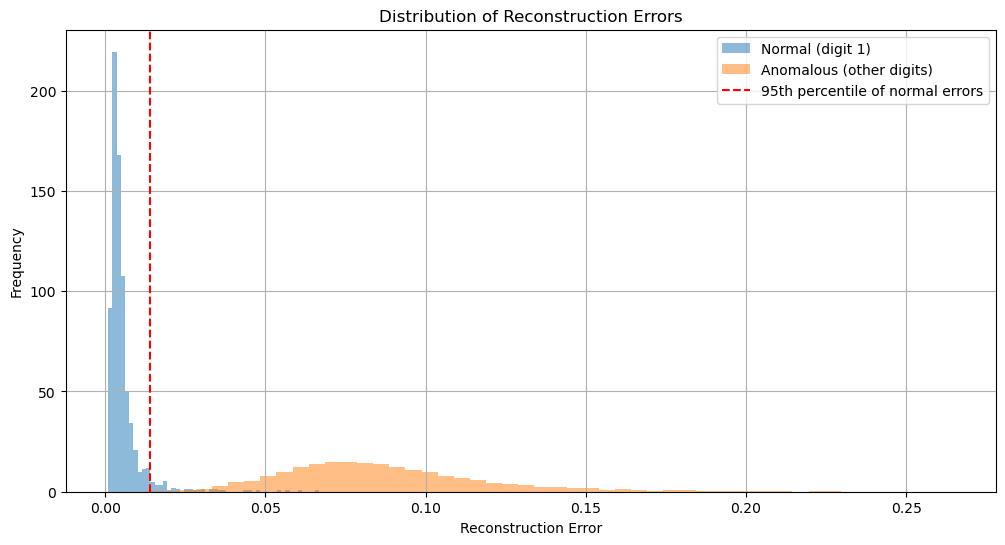

Training with bottleneck size 16
Epoch [1/20], Loss: 0.054603
Epoch [2/20], Loss: 0.015463
Epoch [3/20], Loss: 0.012481
Epoch [4/20], Loss: 0.010290
Epoch [5/20], Loss: 0.009138
Epoch [6/20], Loss: 0.007660
Epoch [7/20], Loss: 0.006360
Epoch [8/20], Loss: 0.005295
Epoch [9/20], Loss: 0.004726
Epoch [10/20], Loss: 0.004392
Epoch [11/20], Loss: 0.004105
Epoch [12/20], Loss: 0.003887
Epoch [13/20], Loss: 0.003713
Epoch [14/20], Loss: 0.003559
Epoch [15/20], Loss: 0.003472
Epoch [16/20], Loss: 0.003357
Epoch [17/20], Loss: 0.003256
Epoch [18/20], Loss: 0.003163
Epoch [19/20], Loss: 0.003074
Epoch [20/20], Loss: 0.002994
Training with bottleneck size 32
Epoch [1/20], Loss: 0.052463
Epoch [2/20], Loss: 0.015681
Epoch [3/20], Loss: 0.012070
Epoch [4/20], Loss: 0.009326
Epoch [5/20], Loss: 0.007100
Epoch [6/20], Loss: 0.006094
Epoch [7/20], Loss: 0.005408
Epoch [8/20], Loss: 0.004912
Epoch [9/20], Loss: 0.004495
Epoch [10/20], Loss: 0.004159
Epoch [11/20], Loss: 0.003894
Epoch [12/20], Loss: 0

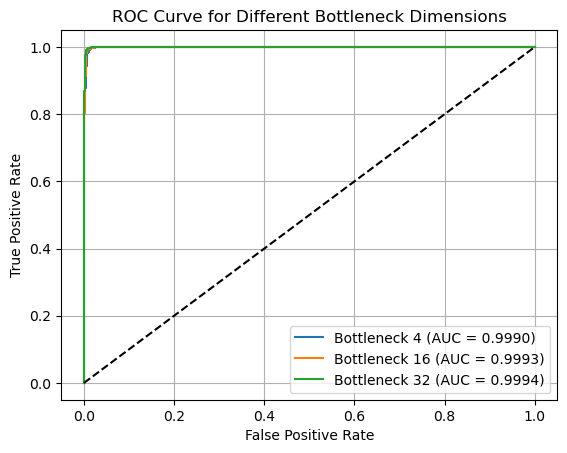

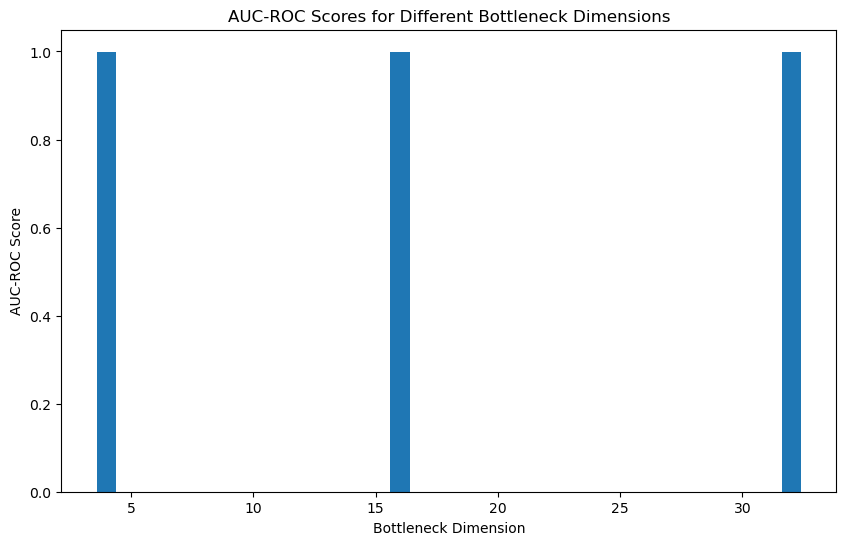


Best bottleneck dimension: 32 with AUC-ROC: 0.9994


In [12]:
def compute_reconstruction_errors(model, data_loader):
    model.eval()
    errors, labels = [], []
    criterion = nn.MSELoss(reduction='none')
    
    with torch.no_grad():
        for images, lbls in data_loader:
            images = images.to(device)
            outputs = model(images)
            loss = criterion(outputs, images)
            loss = loss.view(loss.shape[0], -1).mean(dim=1)
            errors.extend(loss.cpu().numpy())
            labels.extend(lbls.numpy())
    return np.array(errors), np.array(labels)

def plot_reconstruction_error_histogram(errors, labels, normal_digit):
    plt.figure(figsize=(12, 6))
    binary_labels = (labels != normal_digit).astype(int)
    normal_errors = errors[binary_labels == 0]
    anomalous_errors = errors[binary_labels == 1]
    
    plt.hist(normal_errors, bins=50, alpha=0.5, label=f'Normal (digit {normal_digit})', density=True)
    plt.hist(anomalous_errors, bins=50, alpha=0.5, label='Anomalous (other digits)', density=True)
    
    plt.axvline(x=np.percentile(normal_errors, 95), color='red', linestyle='--', 
                label='95th percentile of normal errors')
    
    plt.xlabel('Reconstruction Error')
    plt.ylabel('Frequency')
    plt.title('Distribution of Reconstruction Errors')
    plt.legend()
    plt.grid(True)
    plt.savefig('reconstruction_error_histogram.png')
    plt.show()
    plt.close()

# Training and Evaluation
results = {}
plt.figure(figsize=(10, 8))

for bottleneck in BOTTLENECK_SIZES:
    print(f"Training with bottleneck size {bottleneck}")
    model = AutoEncoder(bottleneck).to(device)
    train_losses = train_autoencoder(model, norm_train_loader)
    torch.save(model.state_dict(), f"autoencoder_bottleneck_{bottleneck}.pth")
    
    errors, labels = compute_reconstruction_errors(model, test_loader)
    normal_errors = errors[labels == NORMAL_DIGIT]
    anomaly_errors = errors[labels != NORMAL_DIGIT]
    
    if bottleneck == BOTTLENECK_SIZES[0]:
        threshold = np.percentile(normal_errors, 95)
        print("Threshold:", threshold)
        predictions = errors > threshold
        ground_truth = labels != NORMAL_DIGIT
        precision, recall, f1, _ = precision_recall_fscore_support(ground_truth, predictions, average='binary')
        print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1-score: {f1:.4f}")
        plot_reconstruction_error_histogram(errors, labels, NORMAL_DIGIT)
    
    fpr, tpr, _ = roc_curve(labels != NORMAL_DIGIT, errors)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Bottleneck {bottleneck} (AUC = {roc_auc:.4f})')
    
    results[bottleneck] = {'auc': roc_auc, 'fpr': fpr, 'tpr': tpr}

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for Different Bottleneck Dimensions")
plt.legend(loc='lower right')
plt.grid(True)
plt.savefig('roc_curves.png')
plt.show()
plt.close()

bottleneck_dims = list(results.keys())
auc_scores = [results[dim]['auc'] for dim in bottleneck_dims]

plt.figure(figsize=(10, 6))
plt.bar(bottleneck_dims, auc_scores)
plt.xlabel("Bottleneck Dimension")
plt.ylabel("AUC-ROC Score")
plt.title("AUC-ROC Scores for Different Bottleneck Dimensions")
plt.savefig('auc_comparison.png')
plt.show()
plt.close()

best_dim = bottleneck_dims[np.argmax(auc_scores)]
print(f"\nBest bottleneck dimension: {best_dim} with AUC-ROC: {max(auc_scores):.4f}")

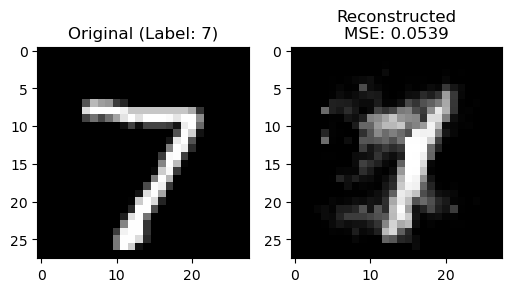

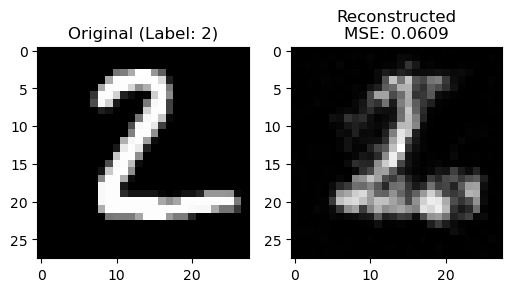

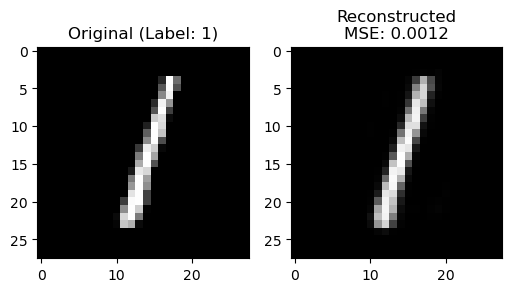

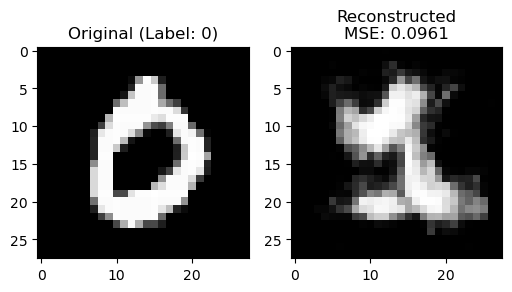

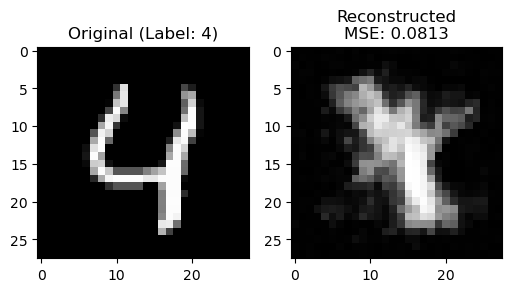

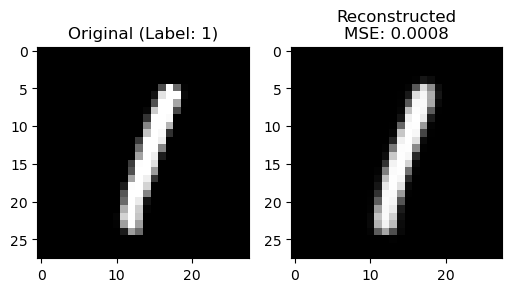

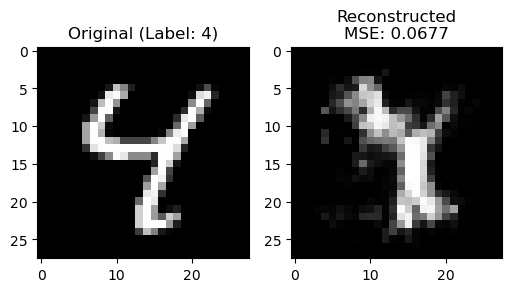

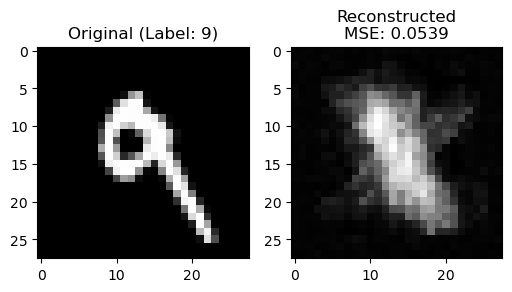

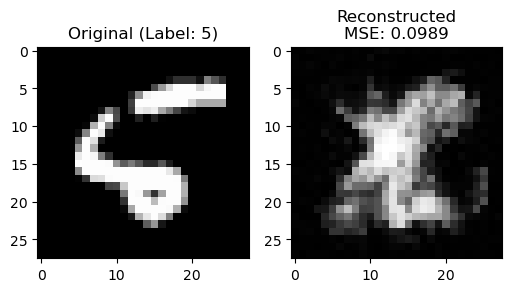

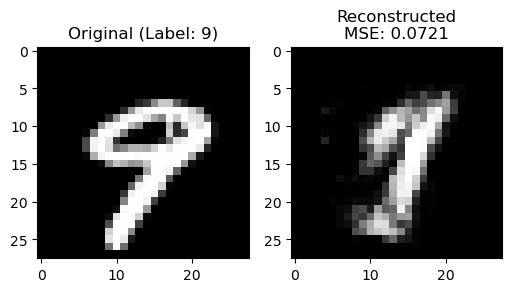

In [13]:
import matplotlib.pyplot as plt
import torch

def test_single_digit(model, test_loader, index=0):
    model.eval()
    images, labels = next(iter(test_loader))
    image = images[index].unsqueeze(0).to(device)
    
    with torch.no_grad():
        reconstructed = model(image)

    image = image.cpu().squeeze().numpy()
    reconstructed = reconstructed.cpu().squeeze().numpy()
    
    mse_loss = ((image - reconstructed) ** 2).mean()
    
    fig, axs = plt.subplots(1, 2, figsize=(6, 3))
    axs[0].imshow(image, cmap="gray")
    axs[0].set_title(f"Original (Label: {labels[index].item()})")
    
    axs[1].imshow(reconstructed, cmap="gray")
    axs[1].set_title(f"Reconstructed\nMSE: {mse_loss:.4f}")
    
    plt.show()

for i in range(10):
    test_single_digit(model, test_loader, index=i)